In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# imports and configs

from datetime import datetime, date
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import world_bank_data as wb
import importlib

# make plots a bit bigger
plt.rcParams["figure.figsize"] = [30, 15]

# make cells wider
# https://stackoverflow.com/questions/21971449/how-do-i-increase-the-cell-width-of-the-jupyter-ipython-notebook-in-my-browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# control how data is display in pandas
# https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html
pd.options.display.max_rows = 20
pd.options.display.expand_frame_repr = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from covid19plot.data import importdata

data = importdata()
print(data.keys())
#data.df


dict_keys(['numericalcolors', 'aggregation', 'df', 'numericalbase'])


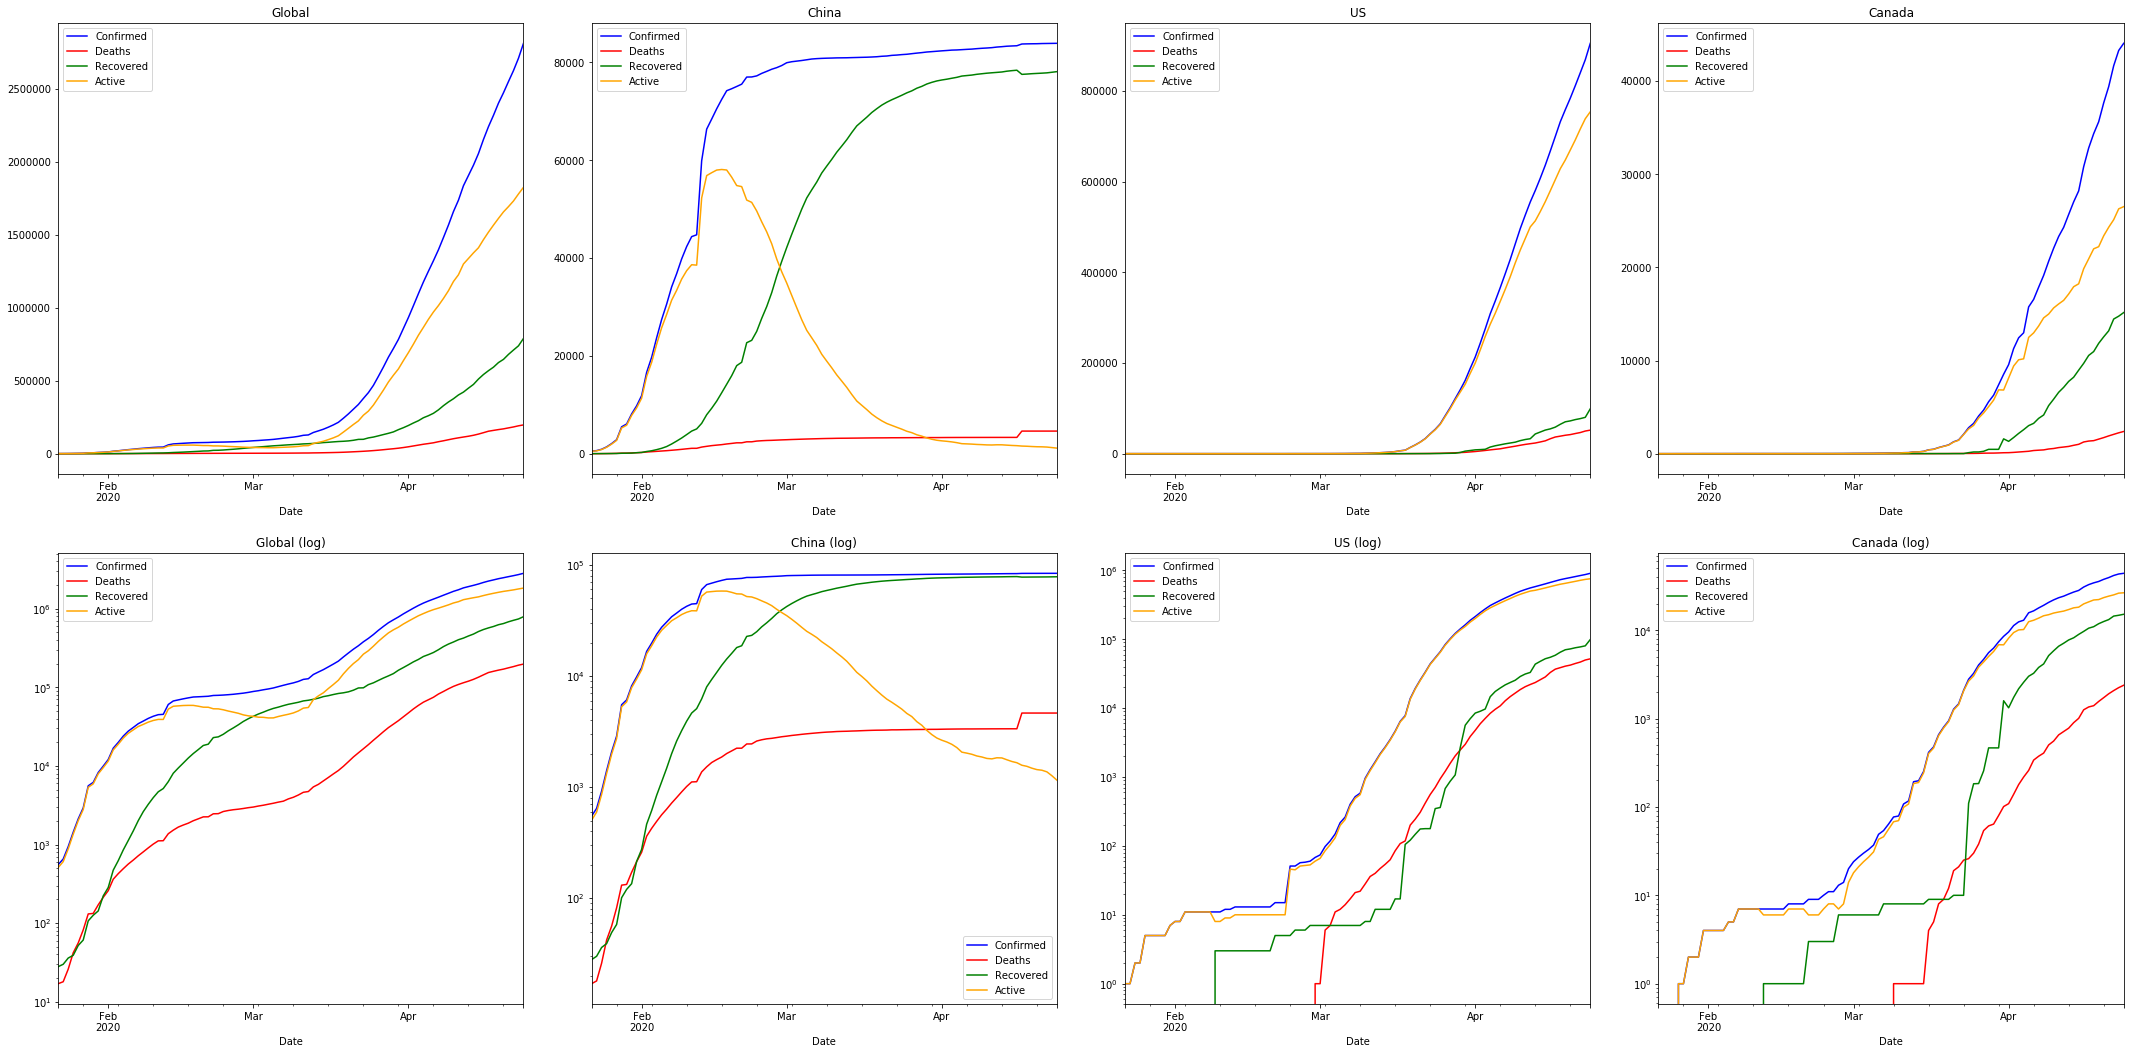

In [5]:
from covid19plot.plot import countryplot
plt.rcParams["figure.figsize"] = [30, 15]

fig = countryplot(data, ['Global', 'China', 'US', 'Canada'])

fig.tight_layout(pad=2.0)
fig.savefig('out/simple.png')
plt.show()


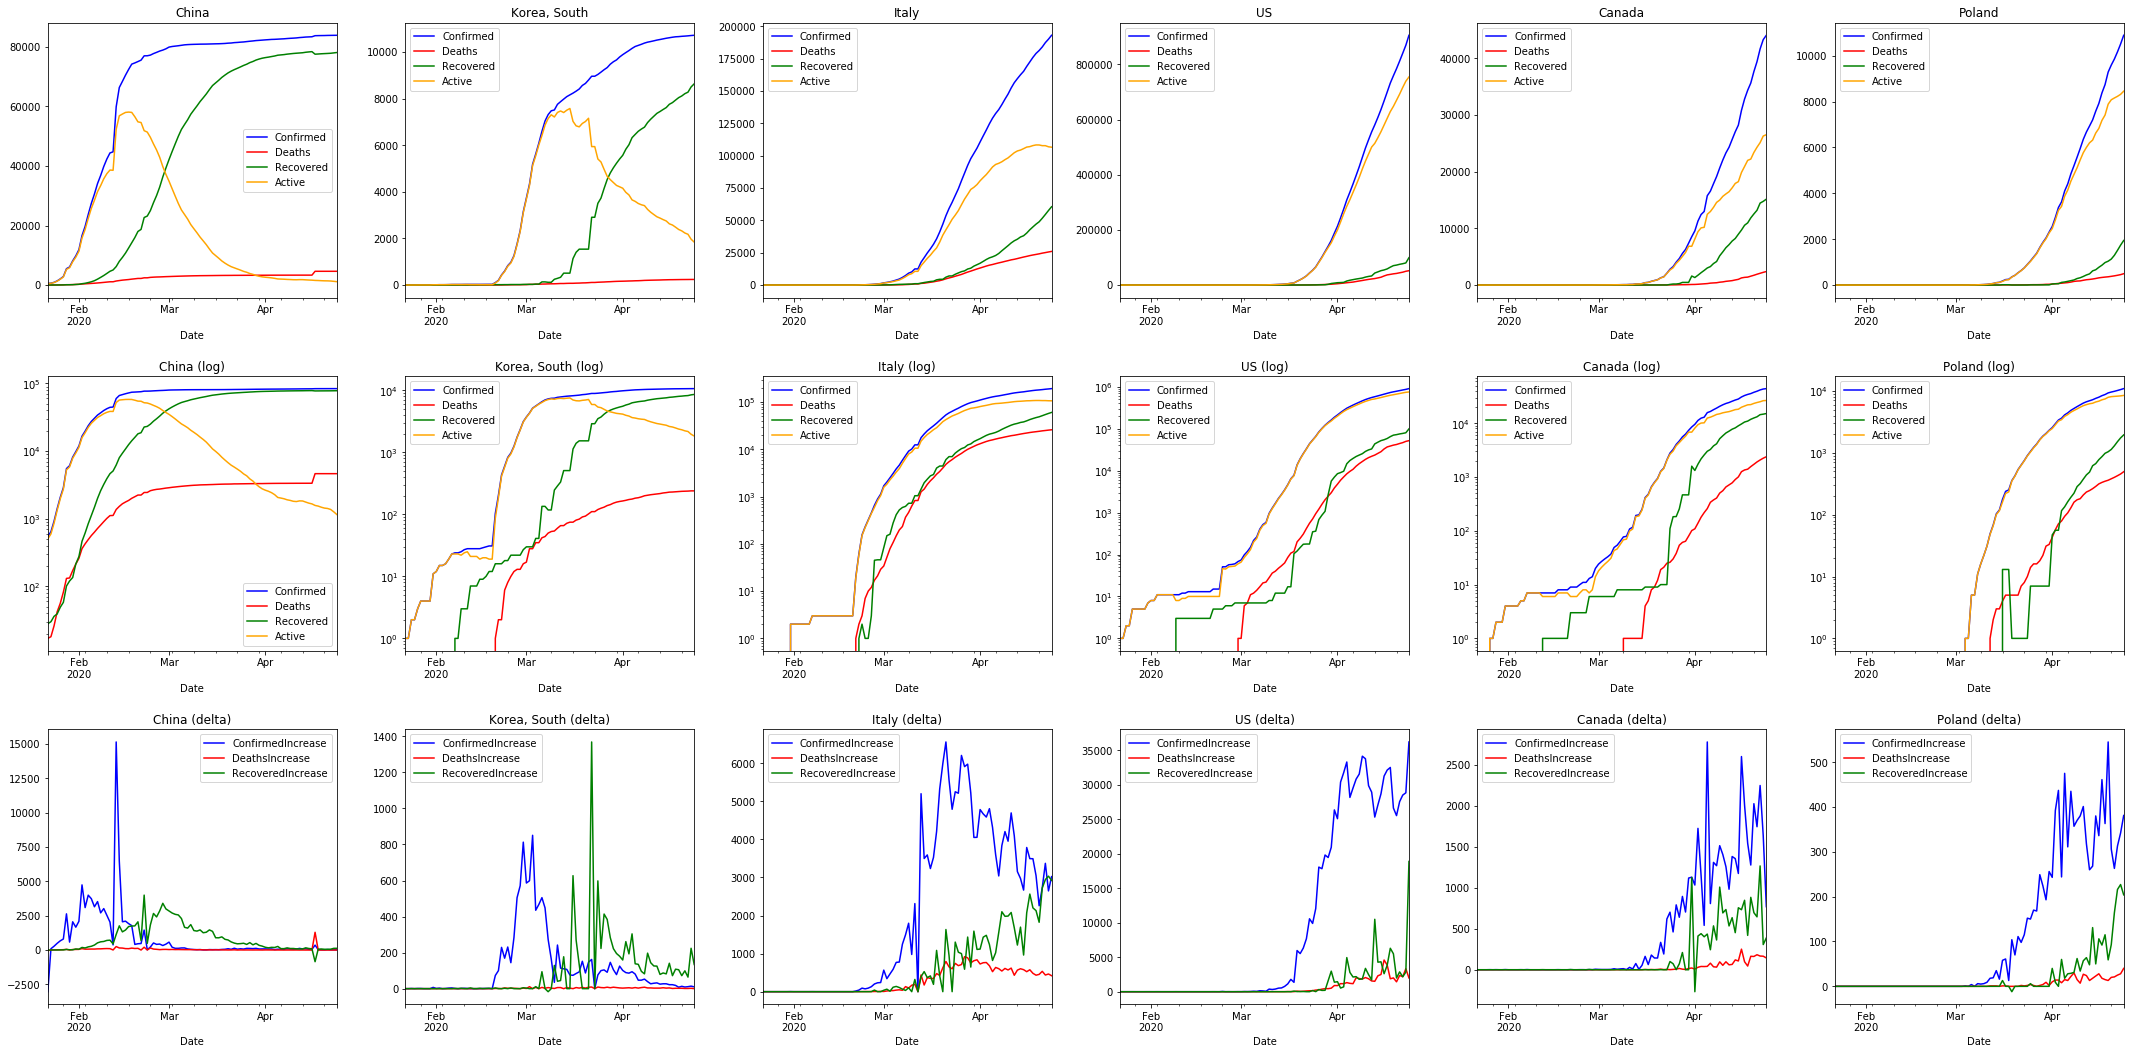

In [6]:
from covid19plot.plot import countryplot
plt.rcParams["figure.figsize"] = [30, 15]

#print(df['Country/Region'].unique())
countries = ['China', 'Korea, South', 'Italy', 'US', 'Canada', 'Poland']

fig = countryplot(data, countries, showIncrease=True)

fig.tight_layout(pad=2.0)
fig.savefig('out/countries.png')
plt.show()


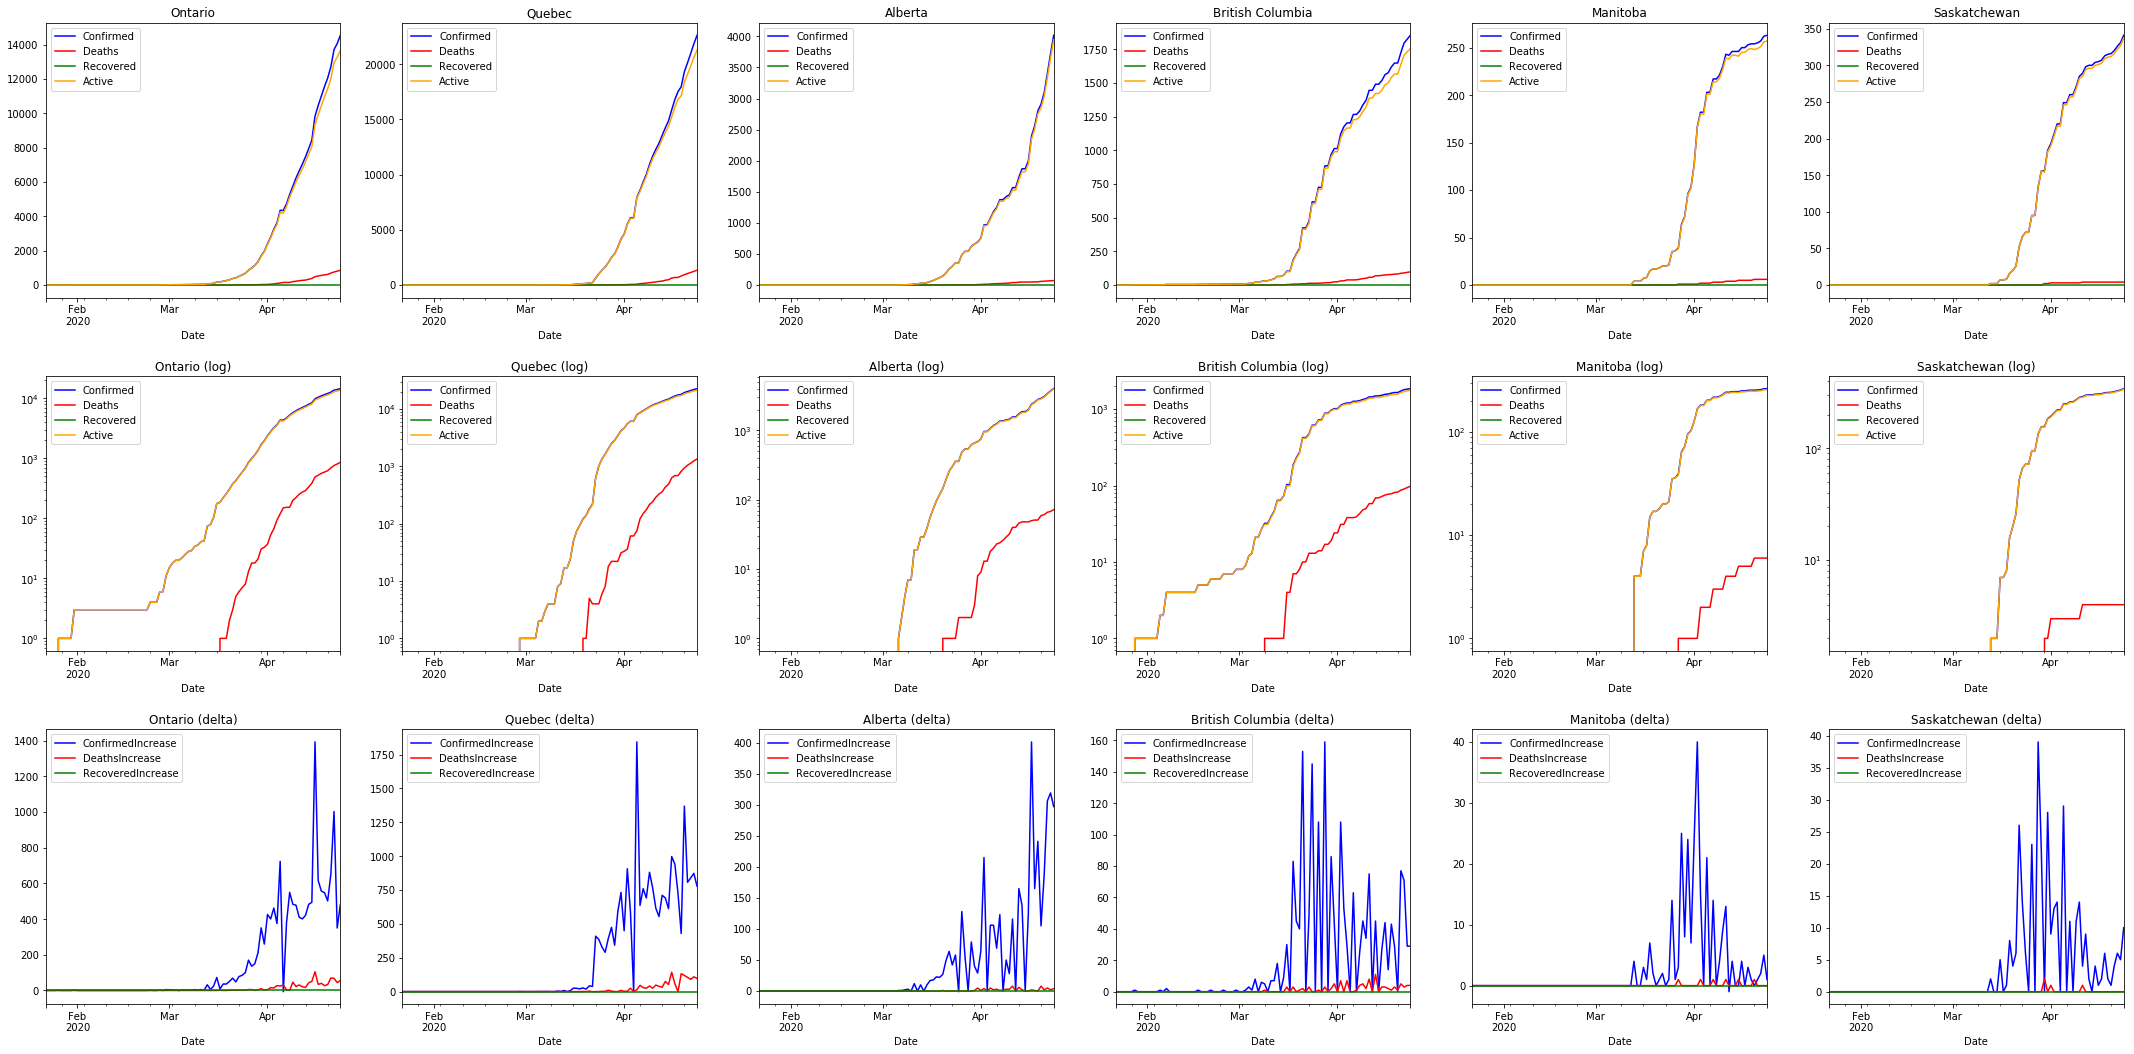

In [7]:
from covid19plot.plot import countryregionplot
plt.rcParams["figure.figsize"] = [30, 15]

country = 'Canada'
regions = ['Ontario', 'Quebec', 'Alberta', 'British Columbia', 'Manitoba', 'Saskatchewan']

#cdf = df.loc[df['Country/Region'] == country]
#regions = cdf['Province/State'].unique()
#regions = regions[0:8]
#print(regions)

fig = countryregionplot(data, country, regions)

fig.tight_layout(pad=2.0)
fig.savefig('out/canada.png')
plt.show()


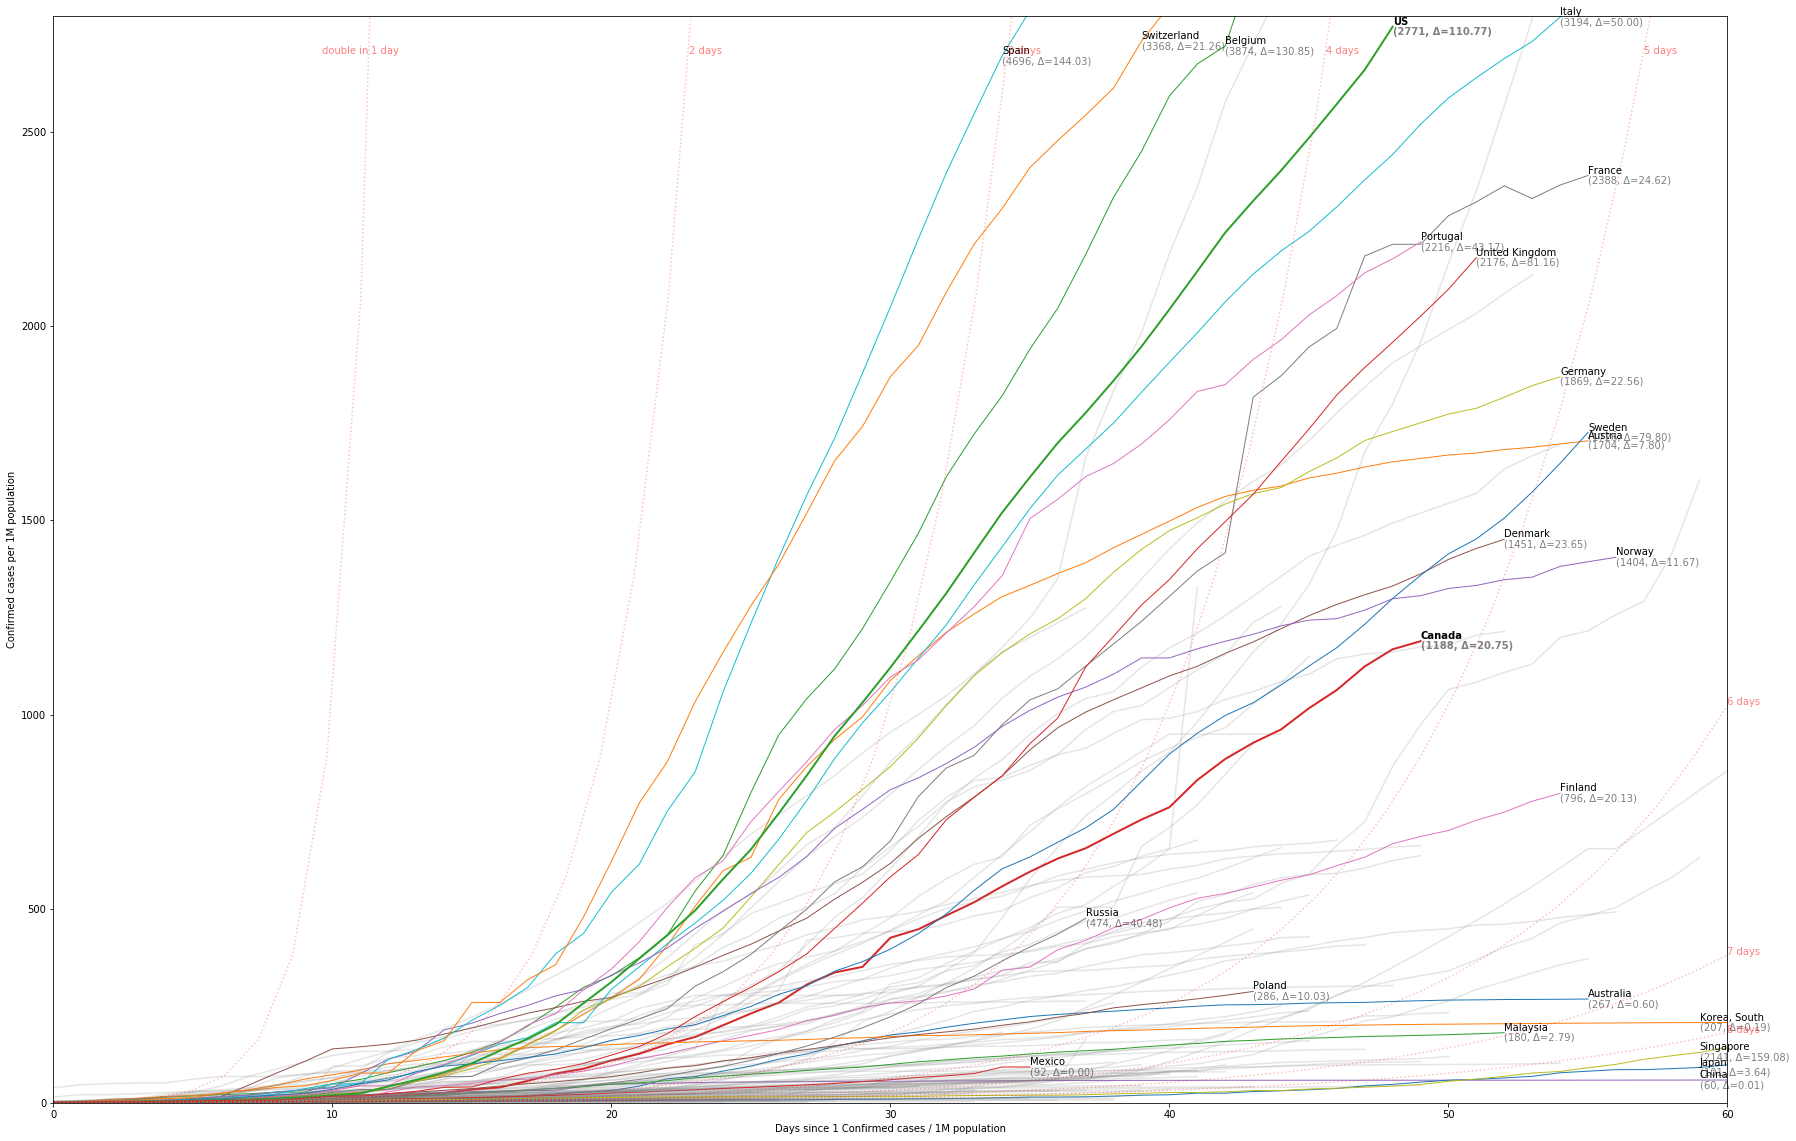

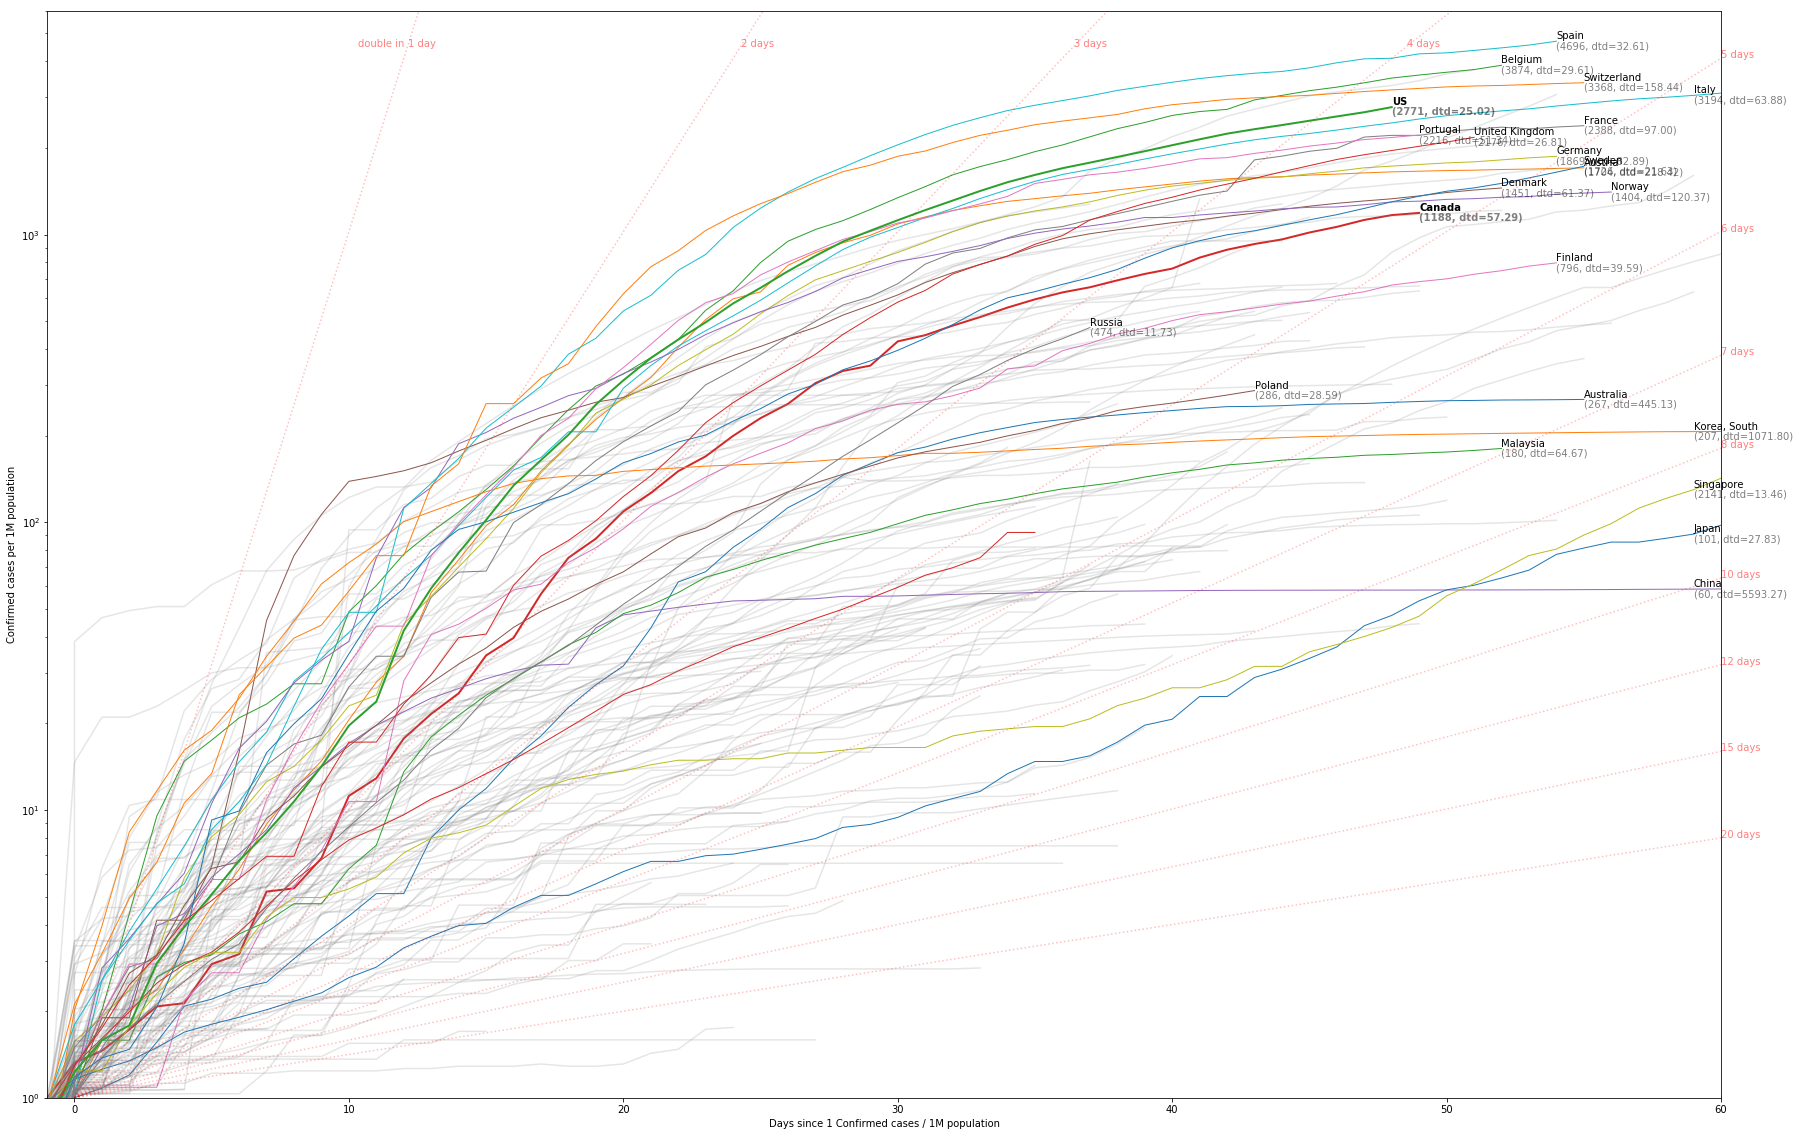

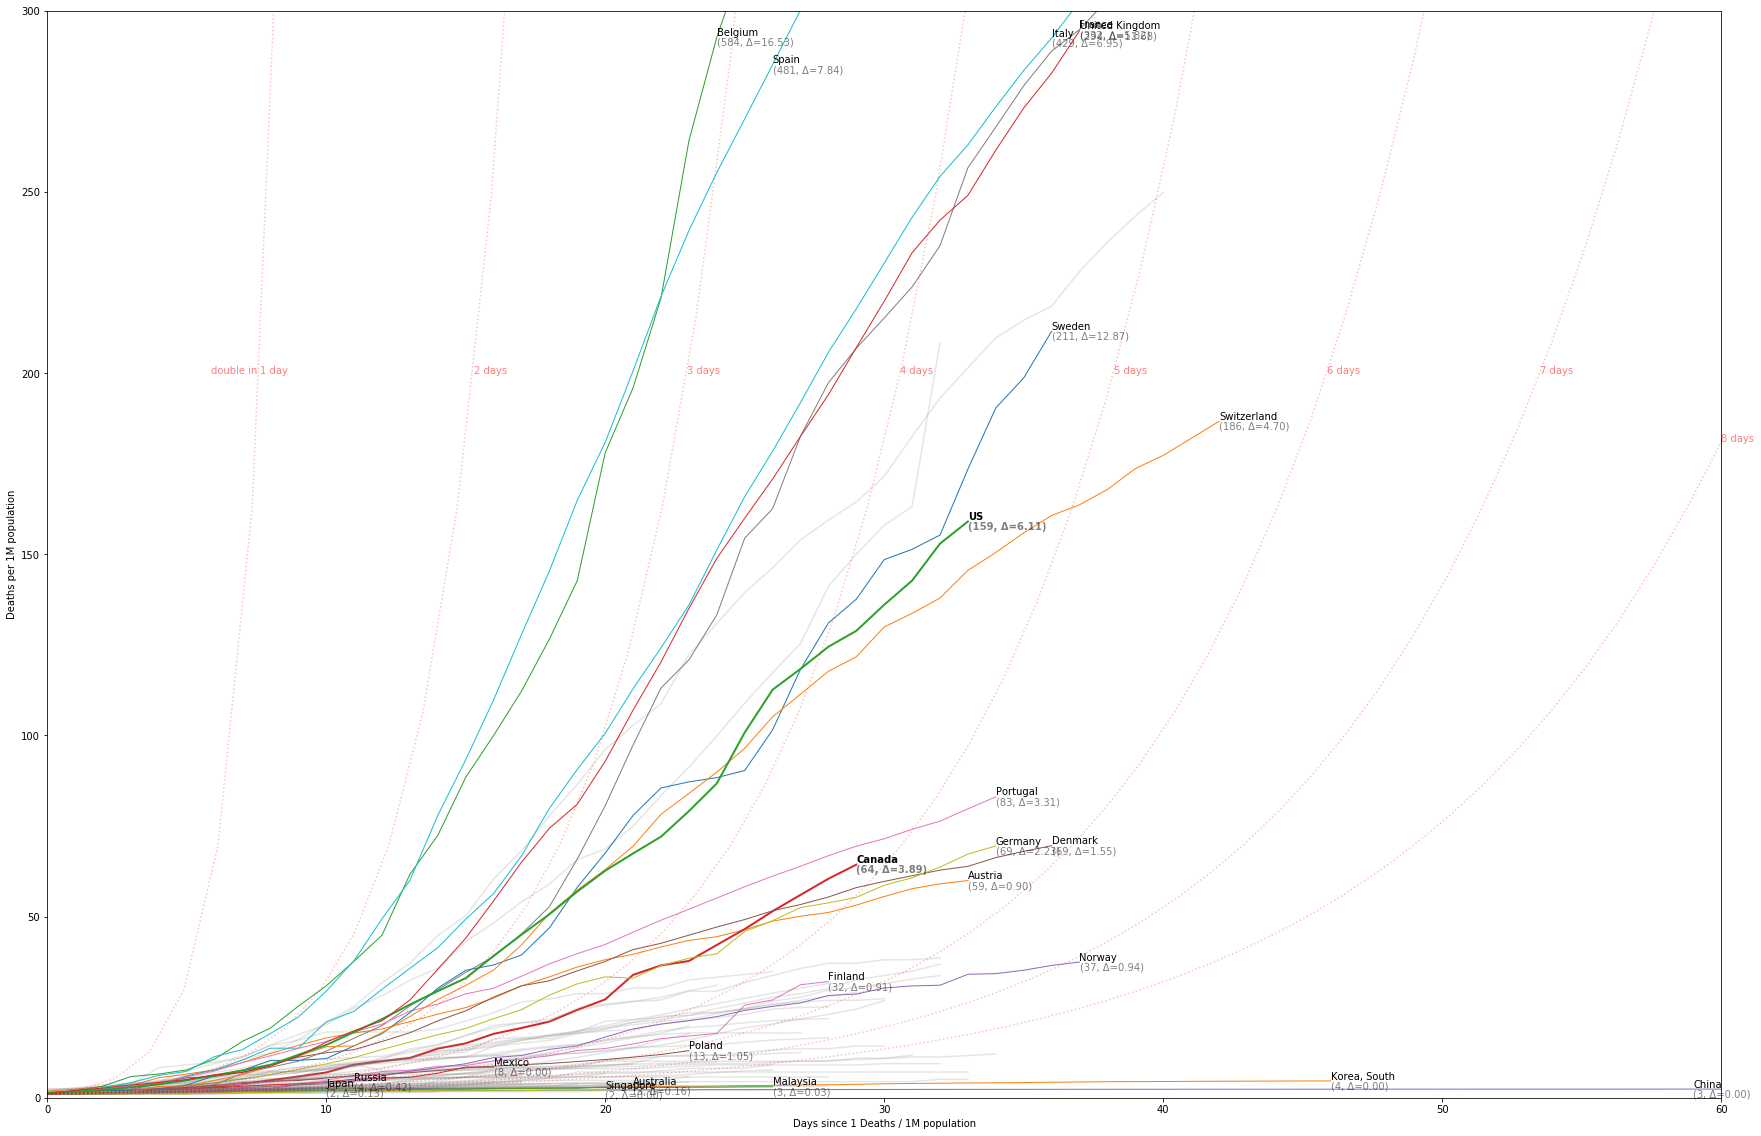

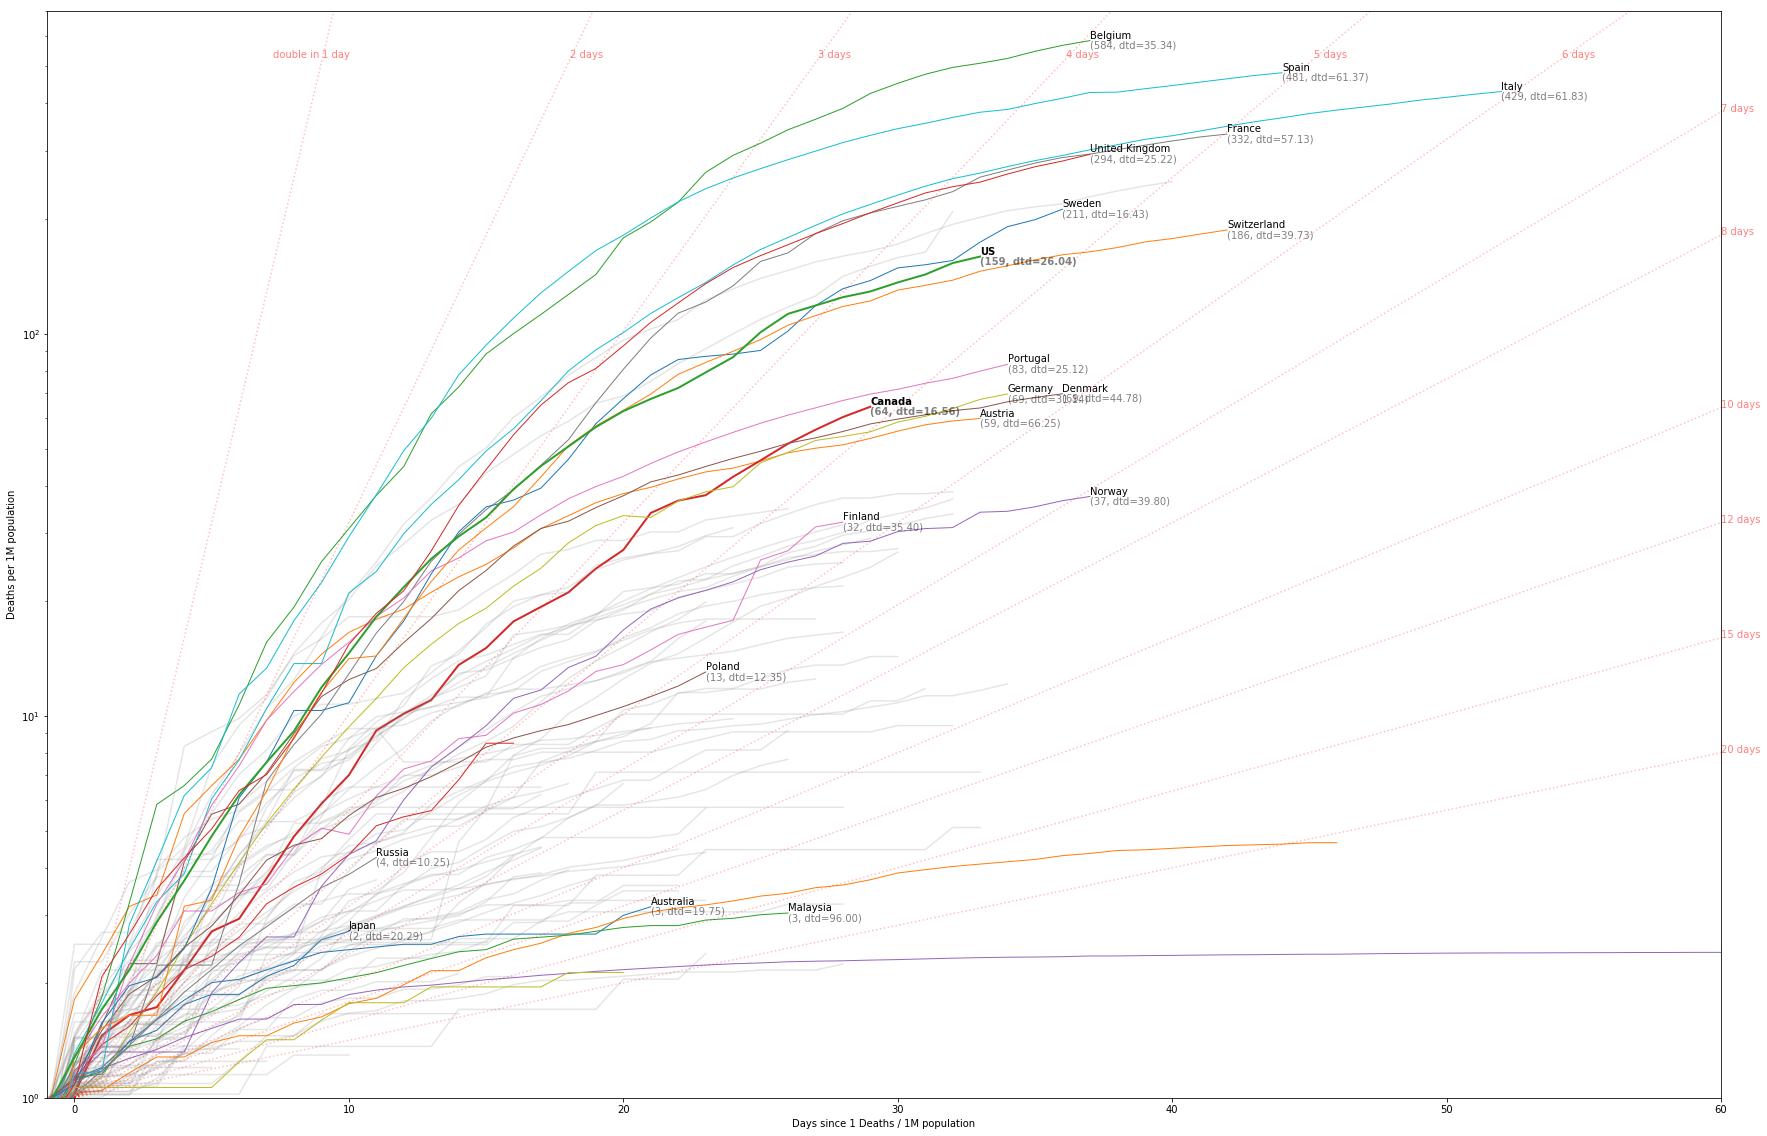

In [8]:
from covid19plot.plot import sinceplot
plt.rcParams["figure.figsize"] = [30, 20]

# confirmed

fig = sinceplot(data, logScale=False, dataColumn='Confirmed')
fig.savefig('out/country-confirmed.png')

fig = sinceplot(data, logScale=True, dataColumn='Confirmed')
fig.savefig('out/country-confirmed-log.png')

# deaths

fig = sinceplot(data, logScale=False, dataColumn='Deaths')
fig.savefig('out/country-deaths.png')

fig = sinceplot(data, logScale=True, dataColumn='Deaths')
fig.savefig('out/country-deaths-log.png')

plt.show()